In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    r2_score,
    root_mean_squared_error,
    make_scorer,
    mean_absolute_percentage_error
)

#Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


In [2]:
# Load csv
df = pd.read_csv("players_data.csv")
print(df.head())

   userNum nickname    gameId  seasonId  gameRank character            weapon  \
0  5426009       마샤  46678118        31         2     Cathy            Dagger   
1  5296453   쿠로미여동생  46678118        31         1     Hisui  Two-handed_Sword   
2  5162955   우주생명마음  46678118        31         5     Adina            Arcana   
3  5140049  只玩过卡拉彼丘  46678118        31         7    Ly Anh            Dagger   
4  5051669  초고교급마다키  46678118        31         7   Tsubame          Shuriken   

         itemWeapon     itemChest        itemHead  ...            Trait_Main1  \
0             Asura  The_Revenant  Imperial_Crown  ...   Unwavering_Mentality   
1  Aurora_Longsword        Áo_Dài  Blaster_Helmet  ...  Contempt_for_the_Weak   
2          The_Moon   Blood_Cloak         Persona  ...            Open_Wounds   
3          Maharaja  Dragon_Dobok      Cowboy_Hat  ...                 Frenzy   
4     Petal_Torrent      Changpao   Crystal_Tiara  ...      Dismantle_Goliath   

    Trait_Main2           

In [3]:
print("Missing values:")
print(df.isnull().sum())


Missing values:
userNum            0
nickname           8
gameId             0
seasonId           0
gameRank           0
character          0
weapon             0
itemWeapon         0
itemChest          0
itemHead           0
itemArm            0
itemLeg            0
Trait_Main1    41064
Trait_Main2    41064
Trait_Sub1       146
Trait_Sub2       512
TeamKill           0
Kill               0
Death              0
Assist             0
Dmg_Player         0
Dmg_Monster        0
dtype: int64


In [4]:
# Drop rows with missing values in key features
df = df.dropna(subset=[
    'character', 'weapon', 'itemWeapon', 'itemChest', 'itemHead',
    'itemArm', 'itemLeg', 'Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2',
    'TeamKill', 'Kill', 'Death', 'Assist', 'Dmg_Player', 'Dmg_Monster', 'gameRank'
])



In [5]:
print(df.head)

<bound method NDFrame.head of         userNum    nickname    gameId  seasonId  gameRank character  \
0       5426009          마샤  46678118        31         2     Cathy   
1       5296453      쿠로미여동생  46678118        31         1     Hisui   
2       5162955      우주생명마음  46678118        31         5     Adina   
3       5140049     只玩过卡拉彼丘  46678118        31         7    Ly Anh   
4       5051669     초고교급마다키  46678118        31         7   Tsubame   
...         ...         ...       ...       ...       ...       ...   
311252   972414       Xepia  47992189        31         8       Eva   
311253   760826      포카칩마시써  47992189        31         7   Tsubame   
311254   387101  Chocodevil  47992189        31         3   Estelle   
311255   350307        토로네스  47992189        31         8      Yuki   
311256   123882        サルナベ  47992189        31         5       Aya   

                  weapon        itemWeapon          itemChest  \
0                 Dagger             Asura       The

In [6]:
print("Missing values:")
print(df.isnull().sum())


Missing values:
userNum        0
nickname       8
gameId         0
seasonId       0
gameRank       0
character      0
weapon         0
itemWeapon     0
itemChest      0
itemHead       0
itemArm        0
itemLeg        0
Trait_Main1    0
Trait_Main2    0
Trait_Sub1     0
Trait_Sub2     0
TeamKill       0
Kill           0
Death          0
Assist         0
Dmg_Player     0
Dmg_Monster    0
dtype: int64


In [7]:
# Features and target
features = [
    'character', 'weapon', 'itemWeapon', 'itemChest', 'itemHead',
    'itemArm', 'itemLeg', 'Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2',
    'TeamKill', 'Kill', 'Death', 'Assist', 'Dmg_Player', 'Dmg_Monster'
]
target = 'gameRank'

X = df[features]
y = df[target]

In [8]:
# Identify categorical and numerical columns
Categorical = X.select_dtypes(include='object').columns.tolist()
Numeric = [col for col in X.columns if col not in Categorical]

In [9]:
# Preprocessor: Ordinal encode categoricals, passthrough numericals
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), Categorical),
        ('num', 'passthrough', Numeric)
    ]
)

In [10]:
# Complete pipeline
CharWin_Pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', HistGradientBoostingRegressor(max_iter=100, random_state=42))
])

In [11]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
#lighter multi model tester
# Sample and prepare dataset
SAMPLE_SIZE = 8000
train_df = X_train.copy()
train_df['label'] = y_train

sampled_df = train_df.sample(n=SAMPLE_SIZE, random_state=42)
X_sampled = sampled_df.drop(columns='label')
y_sampled = sampled_df['label'].values

# Define regression models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_jobs=-1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_jobs=-1, random_state=42),
    "XGBoost": XGBRegressor(n_jobs=-1, random_state=42),
    "LightGBM": LGBMRegressor(n_jobs=-1, random_state=42)
}



# Define scoring metrics
regression_metrics = {
    'r2': 'r2',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error'
}

results = {}

# Evaluate each model
for name, model in models.items():
    print(f"Evaluating {name}...")

    # Hyperparameter tuning if needed
    if name == "Random Forest":
        param_dist = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
        model = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1)

    if name == "Gradient Boosting":
        param_dist = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
        model = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    scores = cross_validate(
        pipeline,
        X_sampled,
        y_sampled,
        cv=3,
        scoring=list(regression_metrics.values()),
        return_train_score=False,
        n_jobs=-1,
        verbose=10
    )

    # Store results
    results[name] = {
        'r2': (scores['test_r2'].mean(), scores['test_r2'].std()),
        'rmse': (-scores['test_neg_root_mean_squared_error'].mean(), scores['test_neg_root_mean_squared_error'].std()),
        'mae': (-scores['test_neg_mean_absolute_error'].mean(), scores['test_neg_mean_absolute_error'].std()),
        'mape': (-scores['test_neg_mean_absolute_percentage_error'].mean(), scores['test_neg_mean_absolute_percentage_error'].std())
    }

# Format as DataFrame
results_df = pd.DataFrame(results).T

# Expand columns
for metric in regression_metrics.keys():
    results_df[[f'{metric}_mean', f'{metric}_std']] = pd.DataFrame(results_df[metric].tolist(), index=results_df.index)

results_df = results_df.drop(columns=regression_metrics.keys())
results_df = results_df.sort_values(by='r2_mean', ascending=False)

# Show results
print(results_df)


Evaluating Linear Regression...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [13]:
cv_results = {
    'model': [],
    'metric': [],
    'score': []
}

# Metric labels
metric_labels = {
    'r2': 'r2',
    'neg_root_mean_squared_error': 'rmse',
    'neg_mean_absolute_error': 'mae',
    'neg_mean_absolute_percentage_error': 'mape'
}

# Evaluate each model
for name, model in models.items():
    print(f"Evaluating {name} (for box)...")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    scores = cross_validate(
        pipeline,
        X_sampled,
        y_sampled,
        cv=3,
        scoring=list(metric_labels.keys()),
        return_train_score=False,
        n_jobs=-1
    )

    for metric, label in metric_labels.items():
        for score in scores[f'test_{metric}']:
            score_val = -score if metric.startswith('neg_') else score
            cv_results['model'].append(name)
            cv_results['metric'].append(label)
            cv_results['score'].append(score_val)

# Only now: convert to DataFrame and plot
cv_results_df = pd.DataFrame(cv_results)

# Plot
plt.figure(figsize=(14, 5 * len(metric_labels)))

for i, metric in enumerate(metric_labels.values(), 1):
    plt.subplot(len(metric_labels), 1, i)
    sns.boxplot(
        x='metric',
        y='score',
        hue='model',
        data=cv_results_df[cv_results_df['metric'] == metric],
        palette='Set2'
    )
    plt.title(f'{metric.upper()} Comparison', fontsize=16)
    plt.xlabel('Metric', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    if metric != 'r2':
        plt.ylabel(f'{metric.upper()} (Lower is Better)')

plt.tight_layout()
plt.show()


Evaluating Linear Regression (for box)...
Evaluating Ridge (for box)...


KeyboardInterrupt: 

In [14]:
#fit the model
CharWin_Pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['character', 'weapon',
                                                   'itemWeapon', 'itemChest',
                                                   'itemHead', 'itemArm',
                                                   'itemLeg', 'Trait_Main1',
                                                   'Trait_Main2', 'Trait_Sub1',
                                                   'Trait_Sub2']),
                                                 ('num', 'passthrough',
                                                  ['TeamKill', 'Kill', 'Death',
                                                   'Assist', 'Dmg_Player',
                                                   'Dmg_Monster'])])),
                ('regressor', HistGradientBoostingRegressor(random_state=42))])

             Feature  Importance
16  num__Dmg_Monster    0.352822
11     num__TeamKill    0.167035
14       num__Assist    0.098760
13        num__Death    0.072198
12         num__Kill    0.032230
6       cat__itemLeg    0.030121
3     cat__itemChest    0.016169
4      cat__itemHead    0.015178
5       cat__itemArm    0.009574
2    cat__itemWeapon    0.008736
15   num__Dmg_Player    0.005054
0     cat__character    0.003345
8   cat__Trait_Main2    0.003153
1        cat__weapon    0.003009
7   cat__Trait_Main1    0.002281
10   cat__Trait_Sub2    0.001289
9    cat__Trait_Sub1    0.000664


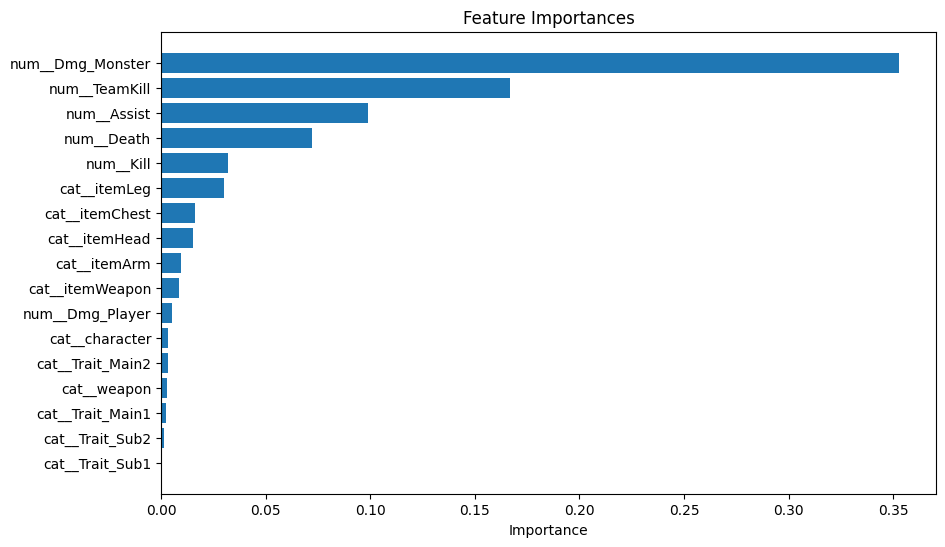

In [ ]:
# Ensure X_train is transformed using the preprocessor before passing it to permutation_importance
X_train_transformed = preprocessor.transform(X_train)

# Get feature importances from the trained model using permutation importance
result = permutation_importance(CharWin_Pipeline.named_steps['regressor'], 
                                X_train_transformed,  # Transformed data
                                y_train,  # your target variable
                                n_repeats=10,  # number of times to shuffle each feature
                                random_state=42)

importances = result.importances_mean

# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Pair the importances with feature names for easier interpretation
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance
print(feature_importance_df)

# Sort and get the top 10
top_n = 10
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()


In [ ]:
#Score
y_pred = CharWin_Pipeline.predict(X_test)
print("R² Score:", round(r2_score(y_test, y_pred), 4))
print("RMSE:", round(root_mean_squared_error(y_test, y_pred, squared=False), 4))

R² Score: 0.7135
RMSE: 1.196


c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


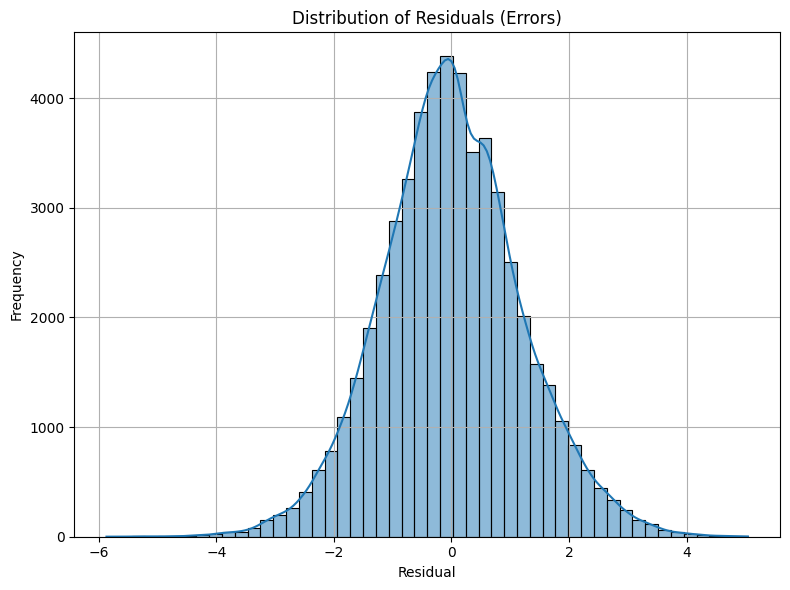

In [23]:
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True, bins=50)
plt.title("Distribution of Residuals (Errors)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

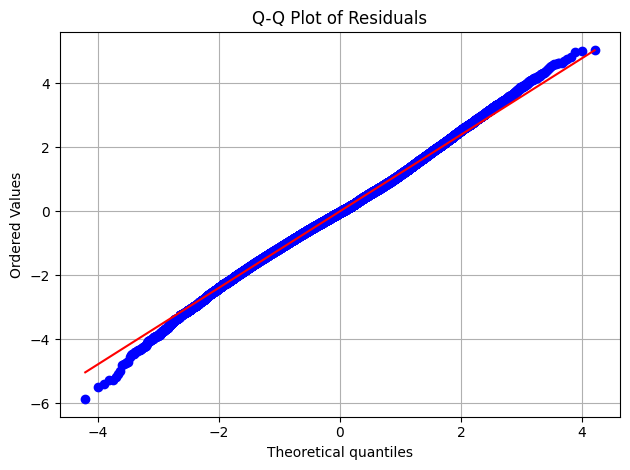

In [21]:
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
def TestCode(character_name, games=50):
    chara = df[df['character'] == character_name]
    if chara.empty:
        return f"No data available for character: {character_name}"

    # Past Data
    avg_rank = chara['gameRank'].mean()
    past_win_rate = (chara['gameRank'] <= 3).mean()

    # Prediction
    X_char = chara[features].copy()
    y_pred = CharWin_Pipeline.predict(X_char)
    pred_win_rate = (y_pred <= 3).mean()
    projected_wins = int(pred_win_rate * games)

    print(f"Performance Summary: {character_name}")
    print(f"Historical Average Rank       : {avg_rank:.2f}")
    print(f"Historical Win Rate (%)       : {past_win_rate * 100:.2f}%")
    print(f"Predicted Win Rate (%)        : {pred_win_rate * 100:.2f}%")
    print(f"Projected Wins in {games} Games:    {projected_wins} Wins\n")


In [77]:
TestCode("Cathy")

Performance Summary: Cathy
Historical Average Rank       : 4.30
Historical Win Rate (%)       : 39.89%
Predicted Win Rate (%)        : 25.95%
Projected Wins in 50 Games:    12 Wins

